In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn as nn
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
model_path = "/data_1/zhoujieli/beta_sheet_classification/esm2_t30_150M_UR50D-150M-finetuned-beta-sheet-jan29/checkpoint-4648"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [3]:
df = pd.read_csv("protein_classification.csv", index_col=0)

In [1]:
df

NameError: name 'df' is not defined

In [4]:
test_sequences = df["data"][df["test"]==1].tolist()
test_labels = df["label"][df["test"]==1].tolist()
test_inputs = tokenizer(test_sequences, return_tensors="pt", padding=True, truncation=True, max_length=1024)
test_dataset = Dataset.from_dict(test_inputs)
test_dataset = test_dataset.add_column("labels", test_labels)

In [5]:
test_inputs["input_ids"].shape

torch.Size([14146, 1024])

In [18]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [19]:
len(test_loader)

111

In [28]:
test_dataset[0]

{'input_ids': [0,
  20,
  15,
  12,
  7,
  4,
  15,
  16,
  7,
  6,
  21,
  19,
  15,
  10,
  13,
  11,
  18,
  4,
  11,
  20,
  6,
  4,
  11,
  5,
  4,
  9,
  7,
  7,
  20,
  9,
  12,
  4,
  4,
  14,
  18,
  12,
  11,
  5,
  12,
  12,
  12,
  13,
  13,
  6,
  4,
  15,
  16,
  8,
  17,
  4,
  14,
  7,
  7,
  12,
  10,
  19,
  6,
  4,
  4,
  20,
  12,
  7,
  20,
  8,
  12,
  12,
  8,
  4,
  23,
  18,
  6,
  5,
  4,
  5,
  6,
  15,
  18,
  5,
  5,
  17,
  5,
  8,
  5,
  6,
  18,
  5,
  5,
  17,
  4,
  10,
  9,
  5,
  12,
  19,
  17,
  17,
  7,
  16,
  11,
  18,
  8,
  18,
  8,
  17,
  12,
  13,
  15,
  18,
  8,
  7,
  14,
  8,
  4,
  7,
  11,
  10,
  20,
  11,
  11,
  13,
  12,
  11,
  17,
  7,
  16,
  4,
  5,
  18,
  20,
  20,
  23,
  11,
  10,
  12,
  5,
  7,
  10,
  5,
  14,
  4,
  17,
  4,
  12,
  18,
  8,
  18,
  5,
  20,
  23,
  20,
  19,
  12,
  23,
  14,
  9,
  12,
  5,
  14,
  11,
  18,
  4,
  12,
  5,
  7,
  12,
  18,
  4,
  20,
  7,
  7,
  4,
  6,
  4,
  12,
  20,
  7,
  7,
  

In [32]:
# Custom collate_fn to handle conversion from lists to tensors
def collate_fn(batch):
    # Convert list of dicts to dict of lists
    batch = {key: [d[key] for d in batch] for key in batch[0]}

    # Convert lists to tensors
    input_ids = torch.tensor(batch['input_ids'])
    attention_mask = torch.tensor(batch['attention_mask'])
    
    # Optionally handle labels if you have them
    if 'labels' in batch:
        labels = torch.tensor(batch['labels'])
        return input_ids, attention_mask, labels

    return input_ids, attention_mask

# Create DataLoader with custom collate_fn
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

In [35]:
test_loader.batch_size

64

In [37]:
from tqdm.auto import tqdm
import torch

# Assuming you have already set your model to evaluation mode using model.eval()

# Set the device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Initialize a list to store the predictions
predictions = []

# Using DataLoader, this loop should iterate over batches
with torch.no_grad():
    for batch in tqdm(test_loader):
        # If your DataLoader is set up correctly, the batch should already contain tensors
        # So you can directly move them to the device
        input_ids, attention_mask = batch[:2]  # If you have labels, they would be in batch[2]
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        # Forward pass, get model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Apply softmax to the logits to get probabilities
        scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Assuming binary classification and you want the probability of the second class
        predicted_probs = scores[:, 1].cpu().numpy()

        # Debug: Check the number of predictions per batch
        print(f"Batch size: {len(predicted_probs)}")

        # Extend the predictions list
        predictions.extend(predicted_probs)

# Debug: Check the total number of predictions
print(f"Total predictions: {len(predictions)}")

# Debug: Check if the number of predictions matches the expected number of data points
assert len(predictions) == len(test_loader.dataset), "Number of predictions does not match number of data points."
# predictions should now be a list of probabilities for the positive class


        

  0%|          | 0/222 [00:00<?, ?it/s]

Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size: 64
Batch size

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

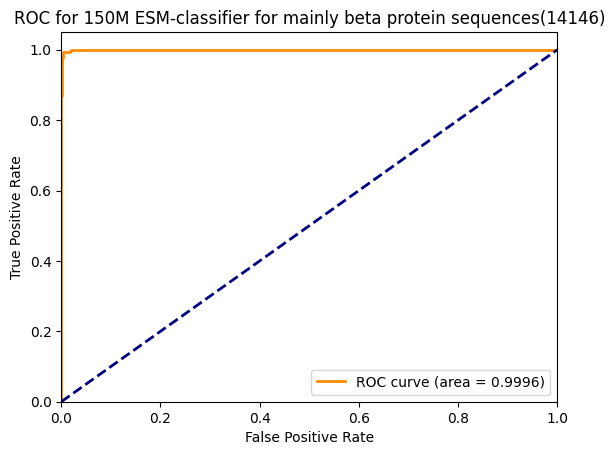

In [56]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # Diagonal 45 degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for 150M ESM-classifier for mainly beta protein sequences(14146)')
plt.legend(loc="lower right")
plt.show()

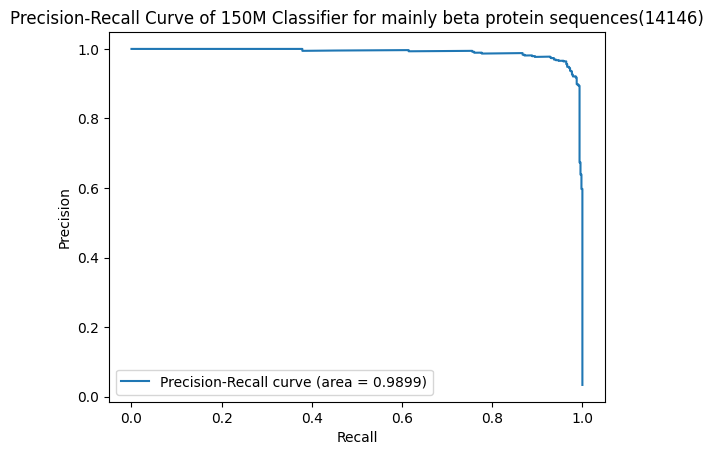

In [58]:
# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
# Calculate the area under the curve
area = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.4f)' % area)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of 150M Classifier for mainly beta protein sequences(14146)')
plt.legend(loc="lower left")
plt.show()

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

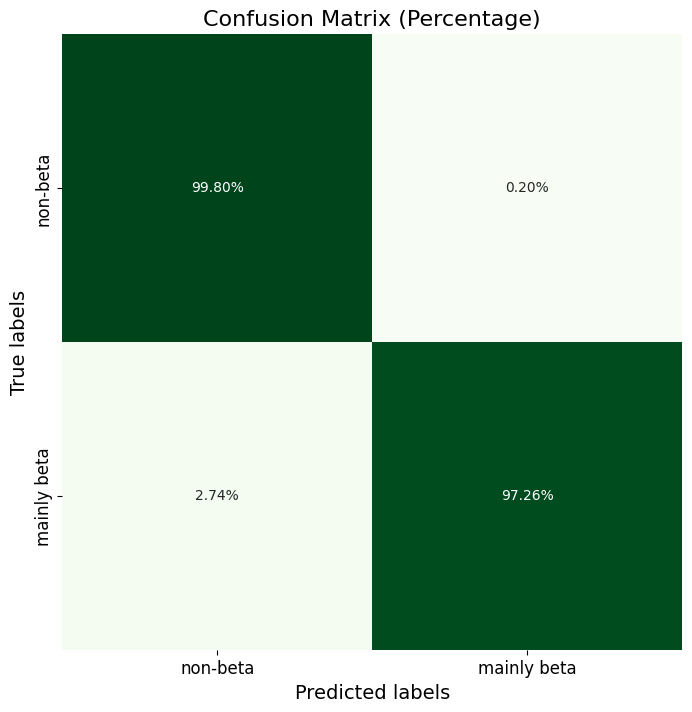

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming `predictions` and `test_labels` are defined and are numpy arrays.
# Convert predictions to a NumPy array if it's not already
predictions = np.array(predictions)

# Apply threshold to predictions to get binary values
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate the confusion matrix and normalize it
cm = confusion_matrix(test_labels, binary_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert the numbers into percentages
cm_percentage = cm_normalized * 100

# Plot the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', ax=ax, cmap=plt.cm.Greens, alpha=1, cbar=False)

# labels, title, and ticks
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Confusion Matrix (Percentage)', fontsize=16)
ax.xaxis.set_ticklabels(['non-beta', 'mainly beta'], fontsize=12)
ax.yaxis.set_ticklabels(['non-beta', 'mainly beta'], fontsize=12)
plt.show()

In [91]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Assuming 'df', 'predictions', 'test_df', 'true_labels' are predefined as per your context

# Apply threshold to predictions to get binary values
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate the confusion matrix and normalize it by the number of instances in each actual class
cm = confusion_matrix(true_labels, binary_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate beta_sheet percentages for all quadrants
beta_sheet_TP = test_df.loc[(binary_predictions == 1) & (test_df["label"] == 1), "beta_sheet"].mean()
beta_sheet_FP = test_df.loc[(binary_predictions == 1) & (test_df["label"] == 0), "beta_sheet"].mean()
beta_sheet_TN = test_df.loc[(binary_predictions == 0) & (test_df["label"] == 0), "beta_sheet"].mean()
beta_sheet_FN = test_df.loc[(binary_predictions == 0) & (test_df["label"] == 1), "beta_sheet"].mean()


In [95]:
beta_sheet_TP, beta_sheet_FP, beta_sheet_TN, beta_sheet_FN

(51.61281385281385, 37.6437037037037, 17.34257988859572, 41.8423076923077)

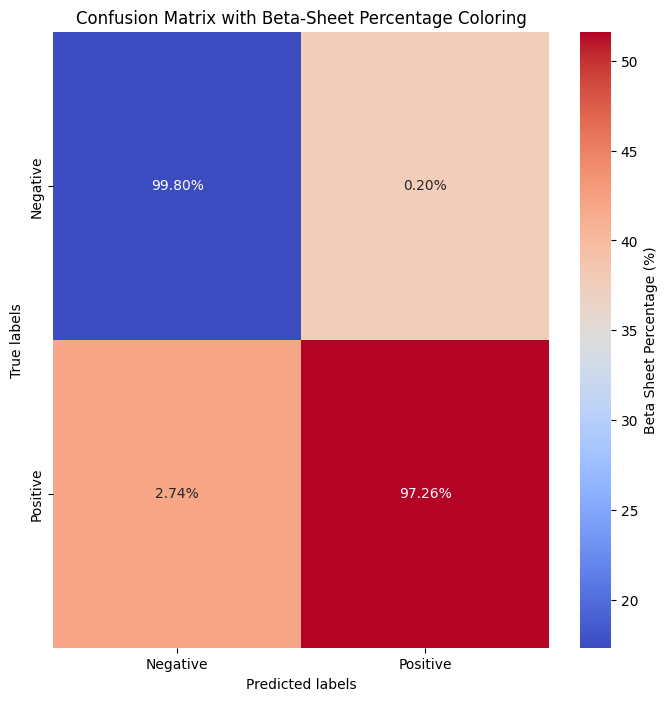

In [98]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df', 'predictions', 'test_df', 'true_labels' are predefined as per your context

# Apply threshold to predictions to get binary values
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate the confusion matrix and normalize it by the number of instances in each actual class
cm = confusion_matrix(true_labels, binary_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate beta_sheet percentages for all quadrants
beta_sheet_values = {
    'TP': test_df[(binary_predictions == 1) & (test_df["label"] == 1)]['beta_sheet'].mean(),
    'FP': test_df[(binary_predictions == 1) & (test_df["label"] == 0)]['beta_sheet'].mean(),
    'TN': test_df[(binary_predictions == 0) & (test_df["label"] == 0)]['beta_sheet'].mean(),
    'FN': test_df[(binary_predictions == 0) & (test_df["label"] == 1)]['beta_sheet'].mean(),
}

# Create a 2x2 matrix for beta_sheet percentages
beta_sheet_matrix = np.array([
    [beta_sheet_values['TN'], beta_sheet_values['FP']],
    [beta_sheet_values['FN'], beta_sheet_values['TP']]
])

# Plotting the confusion matrix with beta_sheet percentage coloring
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(beta_sheet_matrix, annot=cm_normalized, fmt='.2%', ax=ax, cmap='coolwarm', cbar_kws={'label': 'Beta Sheet Percentage (%)'})

# Labels, title, and ticks
label_names = ['Negative', 'Positive']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix with Beta-Sheet Percentage Coloring')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

plt.show()

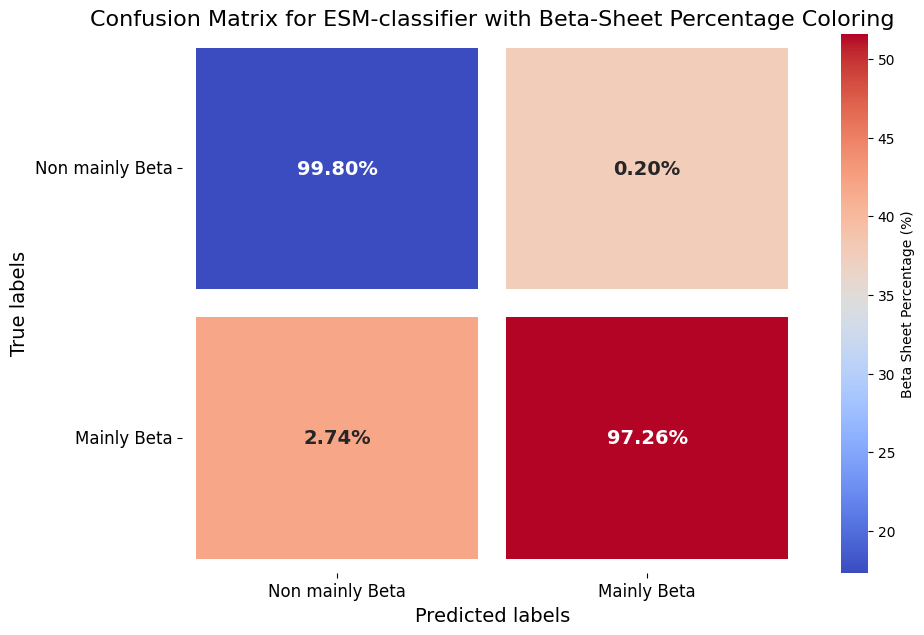

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming beta_sheet_matrix and cm_normalized are already defined as per previous context

# Define the size of the plot
plt.figure(figsize=(10, 7))

# Choose a color map
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Create the heatmap for the confusion matrix with added gapping
sns.heatmap(beta_sheet_matrix, annot=cm_normalized, fmt=".2%", cmap=cmap, linewidths=20, linecolor='white',
            cbar_kws={'label': 'Beta Sheet Percentage (%)'},
            annot_kws={"size": 14, "weight": "bold"})

# Beautifying the plot
plt.title('Confusion Matrix for ESM-classifier with Beta-Sheet Percentage Coloring', fontsize=16)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)

# Tick labels
label_names = ['Non mainly Beta', 'Mainly Beta']
plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0, fontsize=12)
plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0, fontsize=12)

# Display the visualization of the Confusion Matrix.
plt.show()